# Choosing Files for Analysis
This section is dedicated to initializing the `file_paths` array, which contains the paths to all the data files required for our analysis. It's important to ensure that these files are correctly named and located in the accessible directory.

In [101]:
import pandas as pd
import numpy as np

from pynwb import NWBHDF5IO

# list of all file paths
filepath_list = [
    '/data/notebook_files/nwb/sub-10_ses-mouse-10-session-date-2017-09-28-area-RSC-L23-multi-plane-imaging_behavior+ophys.nwb',
    '/data/notebook_files/nwb/sub-10_ses-mouse-10-session-date-2017-10-11-area-RSC-L23-multi-plane-imaging_behavior+ophys.nwb',
    '/data/notebook_files/nwb/sub-10_ses-mouse-10-session-date-2017-11-05-area-RSC-L23-multi-plane-imaging_behavior+ophys.nwb',
    '/data/notebook_files/nwb/sub-3_ses-mouse-3-session-date-2017-05-04-area-RSC-L23-multi-plane-imaging_behavior+ophys.nwb',
    '/data/notebook_files/nwb/sub-3_ses-mouse-3-session-date-2017-05-08-area-RSC-L23-multi-plane-imaging_behavior+ophys.nwb',
    '/data/notebook_files/nwb/sub-3_ses-mouse-3-session-date-2017-05-10-area-RSC-L23-multi-plane-imaging_behavior+ophys.nwb',
    '/data/notebook_files/nwb/sub-3_ses-mouse-3-session-date-2017-05-12-area-RSC-L23-multi-plane-imaging_behavior+ophys.nwb',
    '/data/notebook_files/nwb/sub-3_ses-mouse-3-session-date-2017-05-13-area-RSC-L23-multi-plane-imaging_behavior+ophys.nwb',
    '/data/notebook_files/nwb/sub-3_ses-mouse-3-session-date-2017-05-17-area-RSC-L23-multi-plane-imaging_behavior+ophys.nwb',
    '/data/notebook_files/nwb/sub-3_ses-mouse-3-session-date-2017-05-21-area-RSC-L23-multi-plane-imaging_behavior+ophys.nwb',
    '/data/notebook_files/nwb/sub-3_ses-mouse-3-session-date-2017-05-22-area-RSC-L23-multi-plane-imaging_behavior+ophys.nwb',
    '/data/notebook_files/nwb/sub-3_ses-mouse-3-session-date-2017-05-23-area-RSC-L23-multi-plane-imaging_behavior+ophys.nwb',
    '/data/notebook_files/nwb/sub-4_ses-mouse-4-session-date-2017-05-30-area-RSC-L23-multi-plane-imaging_behavior+ophys.nwb',
    '/data/notebook_files/nwb/sub-4_ses-mouse-4-session-date-2017-06-08-area-RSC-L23-multi-plane-imaging_behavior+ophys.nwb',
    '/data/notebook_files/nwb/sub-5_ses-mouse-5-session-date-2017-06-20-area-RSC-L23-multi-plane-imaging_behavior+ophys.nwb'
]

In [102]:
selected_filepath = filepath_list[3]

# Loading Data for Model Training
Here, we load the data files specified in the previous section into our Python environment. This process involves reading the data from the [NWB](https://www.nwb.org/) files and converting them into a suitable format for analysis.
> Warnings below are due to imports using deprecated versions of hdmf, disregard...

In [103]:
# load the file
io = NWBHDF5IO(selected_filepath, 'r')
nwb = io.read()

# File name
nwb.identifier

/opt/python/envs/default/lib/python3.8/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/opt/python/envs/default/lib/python3.8/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.3.0 because version 0.5.0 is already loaded.
  return func(args[0], **pargs)


'Mouse_3_session_date_2017-05-04'

In [104]:
# Lookup data
forward_and_lateral_position_data = nwb.processing['behavior']['frame_aligned_position']['frame_aligned_forward_and_lateral_position'].data[:]
forward_and_lateral_position_timestamps = nwb.processing['behavior']['frame_aligned_position']['frame_aligned_forward_and_lateral_position'].timestamps[:]
deconvolved_activity_plane_0_data = nwb.processing['ophys']['deconvolved_activity_plane_0'].data[:]
deconvolved_activity_plane_0_timestamps = nwb.processing['ophys']['deconvolved_activity_plane_0'].timestamps[:]
deconvolved_activity_plane_1_data = nwb.processing['ophys']['deconvolved_activity_plane_1'].data[:]
deconvolved_activity_plane_1_timestamps = nwb.processing['ophys']['deconvolved_activity_plane_1'].timestamps[:]
deconvolved_activity_plane_2_data = nwb.processing['ophys']['deconvolved_activity_plane_2'].data[:]
deconvolved_activity_plane_2_timestamps = nwb.processing['ophys']['deconvolved_activity_plane_2'].timestamps[:]
deconvolved_activity_plane_3_data = nwb.processing['ophys']['deconvolved_activity_plane_3'].data[:]
deconvolved_activity_plane_3_timestamps = nwb.processing['ophys']['deconvolved_activity_plane_3'].timestamps[:]

In [105]:
# Create a function to rename DataFrame columns by appending a suffix
def rename_columns(df, suffix):
    return df.rename(columns=lambda x: f'{x}_{suffix}' if x != 'Timestamp' else x)

# Load & prepare virmen position data
position_data = forward_and_lateral_position_data
position_timestamps = forward_and_lateral_position_timestamps
position_df = pd.DataFrame(position_data, columns=['Forward Position', 'Lateral Position'])
position_df['Timestamp'] = position_timestamps
position_df.set_index('Timestamp', inplace=True)

# Load and prepare neural activity data for each plane within file
activity_planes = [deconvolved_activity_plane_0_data, deconvolved_activity_plane_1_data, 
                   deconvolved_activity_plane_2_data, deconvolved_activity_plane_3_data]
activity_timestamps = [deconvolved_activity_plane_0_timestamps, deconvolved_activity_plane_1_timestamps, 
                       deconvolved_activity_plane_2_timestamps, deconvolved_activity_plane_3_timestamps]

# Cleaning the Data
The focus of this section is on cleaning the data. We implement processes to align mismatched rows and remove any inconsistencies or irrelevant data. This step is essential for ensuring the accuracy and reliability of our dataset, thereby laying a solid foundation for any kind of modeling or statistical analysis that follows.

In [106]:
activity_dfs = []
for i, (activity_data, timestamps) in enumerate(zip(activity_planes, activity_timestamps)):
    df = pd.DataFrame(activity_data)
    df['Timestamp'] = timestamps
    df = df.set_index('Timestamp')
    df = rename_columns(df, f'plane_{i}')
    activity_dfs.append(df)

# Synchronize and join DataFrames at each DataFrame's last point
main_df = position_df.join(activity_dfs, how='outer')

# Group the DataFrame into chunks of five and take the first timestamp of each chunk
    # Each plane is captured with an offset TimeStamp
grouped_df = main_df.groupby(np.arange(len(main_df)) // 5)

# Aggregate the data within each chunk and use the first timestamp as the index
final_df = grouped_df.agg('mean')
final_df.index = grouped_df.apply(lambda x: x.index[0])

final_df.head()

,Forward Position,Lateral Position,0_plane_0,1_plane_0,2_plane_0,3_plane_0,4_plane_0,5_plane_0,6_plane_0,7_plane_0,...,119_plane_3,120_plane_3,121_plane_3,122_plane_3,123_plane_3,124_plane_3,125_plane_3,126_plane_3,127_plane_3,128_plane_3
13.9800,NaN,NaN,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14.1470,NaN,NaN,0.301500,0.0,0.440802,0.000000,0.249525,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14.3135,NaN,NaN,0.165536,0.0,0.846380,0.061609,0.257579,0.0,0.0,0.0,...,0.0,0.005631,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14.4805,NaN,NaN,0.255072,0.0,1.102603,0.196141,0.287930,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14.6470,NaN,NaN,0.179500,0.0,1.373213,0.248983,0.236846,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Data Imputation Using IterativeImputer
In this part, we address the challenge of missing data using an advanced technique called IterativeImputer. This method iteratively models each feature with missing values as a function of other features, in a round-robin fashion. It's a sophisticated approach that helps in accurately estimating missing values, thus preserving the integrity of our dataset.

In [107]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Initialize the imputer
imputer = IterativeImputer(max_iter=10, random_state=0)

# Since IterativeImputer works only with num arrays, we need to convert our DataFrame
numerical_data = final_df.to_numpy()

# Run the imputer on the data to clear NaN values
imputed_data = imputer.fit_transform(numerical_data)

# Convert the imputed data back into a DataFrame
final_df_imputed = pd.DataFrame(imputed_data, columns=final_df.columns, index=final_df.index)

final_df_imputed.head()

,Forward Position,Lateral Position,0_plane_0,1_plane_0,2_plane_0,3_plane_0,4_plane_0,5_plane_0,6_plane_0,7_plane_0,...,119_plane_3,120_plane_3,121_plane_3,122_plane_3,123_plane_3,124_plane_3,125_plane_3,126_plane_3,127_plane_3,128_plane_3
13.9800,1.249748,-0.008359,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14.1470,1.156705,-0.066858,0.301500,0.0,0.440802,0.000000,0.249525,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14.3135,1.078317,-0.044926,0.165536,0.0,0.846380,0.061609,0.257579,0.0,0.0,0.0,...,0.0,0.005631,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14.4805,1.161373,-0.022388,0.255072,0.0,1.102603,0.196141,0.287930,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14.6470,1.313599,-0.058736,0.179500,0.0,1.373213,0.248983,0.236846,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Training the Prediction Model
This is a crucial section where we train a machine learning model using our prepared and cleaned dataset. It is trained on the first 80% of the data then predicts the last 20%. Here the mean squared error (MSE) of the models using training data with dropped NaN values and imputed values are printed as well.

In [114]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# Separate our target variables (y) and features (X)
y = final_df.dropna()[['Forward Position', 'Lateral Position']]
X = final_df.dropna().drop(['Forward Position', 'Lateral Position'], axis=1)

# Initialize the RandomForestRegressor
model = RandomForestRegressor(random_state=0)

# Splitting the dataset with dropped NaNs
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"MSE for model with dropped NaNs: {mse}")

# Separate our target variables (y) and features (X)
y_imputed = final_df_imputed[['Forward Position', 'Lateral Position']]
X_imputed = final_df_imputed.drop(['Forward Position', 'Lateral Position'], axis=1)

# Initialize the RandomForestRegressor
imputed_model = RandomForestRegressor(random_state=0)

# Splitting the imputed dataset
X_train_imputed, X_test_imputed, y_train_imputed, y_test_imputed = train_test_split(X_imputed, y_imputed, test_size=0.2, random_state=0, shuffle=False)
imputed_model.fit(X_train_imputed, y_train_imputed)
y_pred_imputed = imputed_model.predict(X_test_imputed)
mse_imputed = mean_squared_error(y_test_imputed, y_pred_imputed)
print(f"MSE for model with imputed data: {mse_imputed}")

MSE for model with dropped NaNs: 0.04715412595503235
MSE for model with imputed data: 0.04621181362248771


# Visualizing Model Predictions
Finally, we focus on visualizing the predictions made by our model. Specifically, we create plots to illustrate how the model performs on the predicted trials. These visualizations are crucial for evaluating the model's effectiveness and for presenting the results in a clear and understandable manner.

In [140]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['text.color'] = 'gray'
plt.rcParams['axes.labelcolor'] = 'gray'
plt.rcParams['xtick.color'] = 'gray'
plt.rcParams['ytick.color'] = 'gray'

# Init first timestamps to X_test
timestamps = X_test.index

# Prepare the actual data for plotting
actual_data = y_test.copy()
actual_data['Timestamp'] = timestamps

# Prepare the predicted data for plotting
predicted_data = pd.DataFrame(y_pred, columns=['Predicted Forward Position', 'Predicted Lateral Position'])
predicted_data['Timestamp'] = timestamps

# Merging the actual and predicted data for easier plotting
merged_data = pd.merge(actual_data, predicted_data, on='Timestamp')

# Predicted data from the model trained on the dataset with dropped NaNs
predicted_dropped_nan = pd.DataFrame(model.predict(X_test), columns=['Predicted Forward Position', 'Predicted Lateral Position'])
predicted_dropped_nan['Timestamp'] = timestamps

# Predicted data from the model trained on the imputed dataset
timestamps_imputed = X_test_imputed.index
predicted_imputed = pd.DataFrame(imputed_model.predict(X_test_imputed), columns=['Predicted Forward Position (Imputed)', 'Predicted Lateral Position (Imputed)'])
predicted_imputed['Timestamp'] = timestamps_imputed

# Merging the actual and predicted data for easier plotting
merged_data_dropped_nan = pd.merge(actual_data, predicted_dropped_nan, on='Timestamp')
merged_data_imputed = pd.merge(actual_data, predicted_imputed, on='Timestamp')

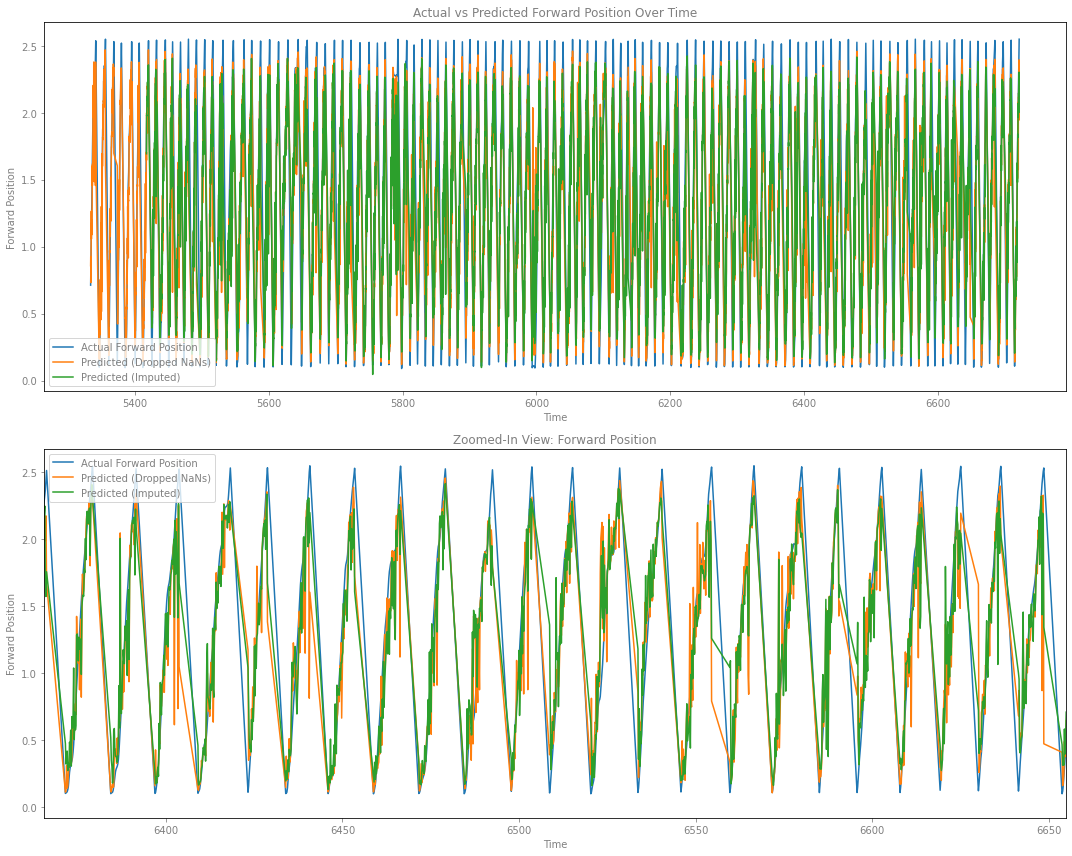

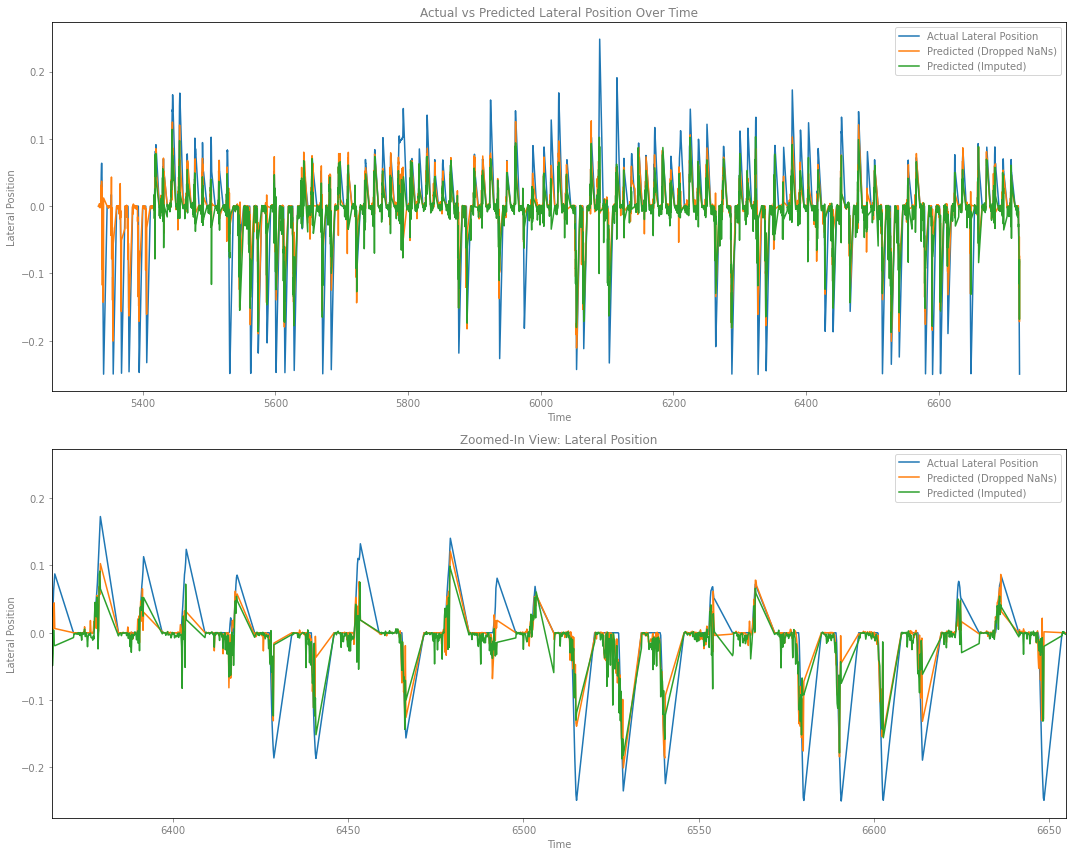

In [141]:
# Define the time range for the zoomed-in view
zoom_start = timestamps[int(len(timestamps) * 0.75)]
zoom_end = timestamps[int(len(timestamps) * 0.95)]

# Plot for Forward Position
fig, axs = plt.subplots(2, 1, figsize=(15, 12))

sns.lineplot(ax=axs[0], data=merged_data_dropped_nan, x='Timestamp', y='Forward Position', label='Actual Forward Position')
sns.lineplot(ax=axs[0], data=merged_data_dropped_nan, x='Timestamp', y='Predicted Forward Position', label='Predicted (Dropped NaNs)')
sns.lineplot(ax=axs[0], data=merged_data_imputed, x='Timestamp', y='Predicted Forward Position (Imputed)', label='Predicted (Imputed)')
axs[0].set_title('Actual vs Predicted Forward Position Over Time')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Forward Position')
axs[0].legend()

# Zoomed-in plot for Forward Position
sns.lineplot(ax=axs[1], data=merged_data_dropped_nan, x='Timestamp', y='Forward Position', label='Actual Forward Position')
sns.lineplot(ax=axs[1], data=merged_data_dropped_nan, x='Timestamp', y='Predicted Forward Position', label='Predicted (Dropped NaNs)')
sns.lineplot(ax=axs[1], data=merged_data_imputed, x='Timestamp', y='Predicted Forward Position (Imputed)', label='Predicted (Imputed)')
axs[1].set_xlim(zoom_start, zoom_end)
axs[1].set_title('Zoomed-In View: Forward Position')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Forward Position')
axs[1].legend()

plt.tight_layout()
plt.show()

# Plot for Lateral Position
fig, axs = plt.subplots(2, 1, figsize=(15, 12))

# Full plot for Lateral Position
sns.lineplot(ax=axs[0], data=merged_data_dropped_nan, x='Timestamp', y='Lateral Position', label='Actual Lateral Position')
sns.lineplot(ax=axs[0], data=merged_data_dropped_nan, x='Timestamp', y='Predicted Lateral Position', label='Predicted (Dropped NaNs)')
sns.lineplot(ax=axs[0], data=merged_data_imputed, x='Timestamp', y='Predicted Lateral Position (Imputed)', label='Predicted (Imputed)')
axs[0].set_title('Actual vs Predicted Lateral Position Over Time')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Lateral Position')
axs[0].legend()

# Zoomed-in plot for Lateral Position
sns.lineplot(ax=axs[1], data=merged_data_dropped_nan, x='Timestamp', y='Lateral Position', label='Actual Lateral Position')
sns.lineplot(ax=axs[1], data=merged_data_dropped_nan, x='Timestamp', y='Predicted Lateral Position', label='Predicted (Dropped NaNs)')
sns.lineplot(ax=axs[1], data=merged_data_imputed, x='Timestamp', y='Predicted Lateral Position (Imputed)', label='Predicted (Imputed)')
axs[1].set_xlim(zoom_start, zoom_end)
axs[1].set_title('Zoomed-In View: Lateral Position')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Lateral Position')
axs[1].legend()

plt.tight_layout()
plt.show()
